# Lab 10 - Fine-Tune VGG16 for Bird Classification
## Sudhan Shrestha - 8889436

In [4]:
# importing the necessary library
import numpy as np
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import shutil
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from keras.utils import to_categorical

In [5]:
# code to make tensors run on GPU
def set_gpu_device():
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        tf.config.set_visible_devices(physical_devices[0], 'GPU')
        tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Calling the function to set GPU device
set_gpu_device()
if tf.config.list_physical_devices('GPU'):
    print("GPU is available!")
else:
    print("No GPU found. TensorFlow will use the CPU.")

GPU is available!


In [6]:
# seting path to the dataset
train_data = pathlib.Path('../../data/lab10/train')
test_data = pathlib.Path('../../data/lab10/test')
valid_data = pathlib.Path('../../data/lab10/valid')

img_count = {}
# finding the top 3 classes
for species in os.listdir(train_data):
    path_species = os.path.join(train_data, species)
    if os.path.isdir(path_species):
        img_count[species] = len(os.listdir(path_species))
        
top_classes = sorted(img_count, key=img_count.get, reverse=True)[:3]
print("Top 3 classes with highest number of images:", top_classes)

Top 3 classes with highest number of images: ['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']


In [7]:
# deleting the other data besides the top 3 classes
folders = [train_data, test_data, valid_data]
for folder in folders:
    for species in os.listdir(folder):
        if species not in top_classes:
            delete_data = os.path.join(folder,species)
            shutil.rmtree(delete_data)

##### Data Augmentation:

In [8]:
# creating data augmentation 
image_size = (224, 224)
batch_size = 64


# using data augmentation, a technique to artificially increase the size of the training dataset by applying various transformations to the existing images.
data_gen = ImageDataGenerator(
    rotation_range=20,
    shear_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip=True,
)


In [9]:
# creating data generators for training, validation, and testing data.
train_generator = data_gen.flow_from_directory(
    train_data,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = data_gen.flow_from_directory(
    valid_data,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = data_gen.flow_from_directory(
    test_data,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


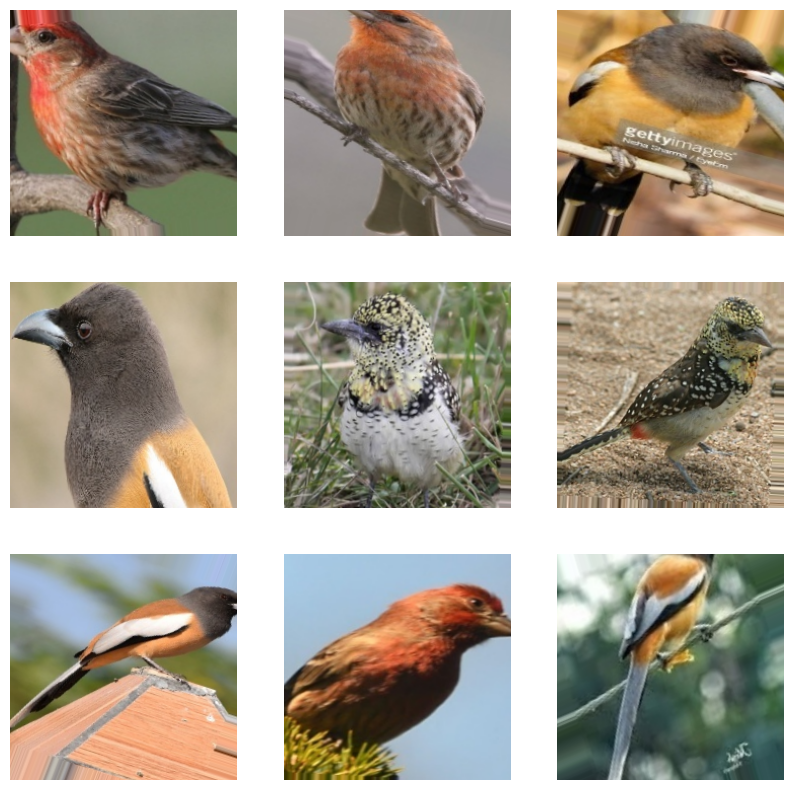

In [10]:
# generating a batch of images from a `train_generator` and displaying them in a 3x3 grid..

images, _ = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.axis("off")
plt.show()

##### VGG16 Model:

In [11]:
'''
Creating a VGG16 model with pre-trained weights from the ImageNet dataset. 
The `VGG16` function is called with the following arguments:
- `weights='imagenet'`: This specifies that the model should be initialized with pre-trained weights from the ImageNet dataset.
- `include_top=False`: This specifies that the fully connected layers at the top of the network should not be included.
- `input_shape=(244,244,3)`: This specifies the shape of the input images that the model will expect.
'''
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(244,244,3)
)
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 61, 61, 128)       0     

In [12]:
# setting the `trainable` attribute of the `conv_base` object to `False`. This means that the weights of the layers in `conv_base` will not be updated during training.
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 61, 61, 128)       0     

In [13]:
# creating a new model by adding additional layers on top of an existing model `conv_base`.
x = conv_base.output
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(conv_base.input, outputs)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 61, 61, 128)       0     

In [15]:
# compiling and training a neural network model.
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="../../data/models/fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks = callbacks
)

Epoch 1/10
12/12 [==============================] - 36s 2s/step - loss: 24.0151 - accuracy: 0.4247 - val_loss: 10.2846 - val_accuracy: 0.5333
Epoch 2/10
12/12 [==============================] - 8s 674ms/step - loss: 9.9647 - accuracy: 0.6425 - val_loss: 4.1787 - val_accuracy: 0.6000
Epoch 3/10
12/12 [==============================] - 8s 654ms/step - loss: 6.4454 - accuracy: 0.7742 - val_loss: 0.8291 - val_accuracy: 0.8000
Epoch 4/10
12/12 [==============================] - 8s 625ms/step - loss: 4.7755 - accuracy: 0.8320 - val_loss: 0.1279 - val_accuracy: 0.9333
Epoch 5/10
12/12 [==============================] - 8s 642ms/step - loss: 3.3451 - accuracy: 0.8683 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 6/10
12/12 [==============================] - 7s 591ms/step - loss: 2.7892 - accuracy: 0.8925 - val_loss: 1.1134 - val_accuracy: 0.9333
Epoch 7/10
12/12 [==============================] - 8s 616ms/step - loss: 1.6265 - accuracy: 0.9086 - val_loss: 7.1526e-08 - val_accuracy: 1.0000
Ep

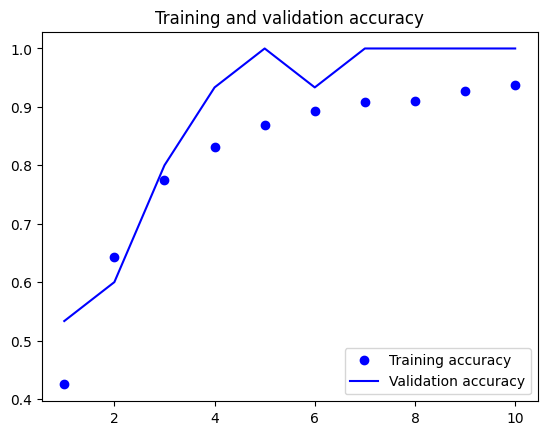

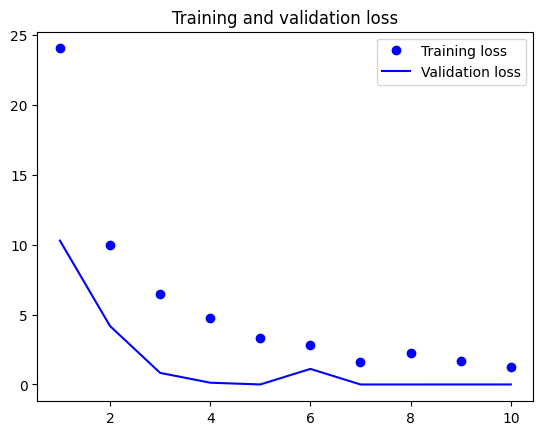

In [16]:
# plotting the training and validation accuracy as well as the training and validation loss over the epochs of a model training process.
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

##### Perfomance Metrics:

In [17]:
# evaluating the performance of the model on a test dataset.
test_loss, test_acc = model.evaluate(test_generator)
val_loss, val_acc = model.evaluate(val_generator)
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test Loss: {test_loss:.3f}\n")
print(f"Validation accuracy: {val_acc:.3f}")
print(f"Validation Loss: {val_loss:.3f}")

1/1 [==============================] - 0s 242ms/step - loss: 0.1639 - accuracy: 0.9333
Test accuracy: 1.000
Test Loss: 0.001

Validation accuracy: 0.933
Validation Loss: 0.164


The accuracy on test set is 100% while on validation is around 93.3%. While this does show promising results for prediciton on new data the perfomance might be due to the small representation of data of various classes.

In [18]:
# generating confusion metrics and classification report for the model.
y_pred = model.predict(test_generator)
y_predict =  np.argmax(y_pred, axis =1)
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true,y_predict)
class_report = classification_report(y_true, y_predict, target_names=test_generator.class_indices.keys())
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


1/1 [==============================] - 0s 323ms/step
Confusion Matrix:
 [[3 1 1]
 [1 3 1]
 [1 1 3]]

Classification Report:
                   precision    recall  f1-score   support

D-ARNAUDS BARBET       0.60      0.60      0.60         5
     HOUSE FINCH       0.60      0.60      0.60         5
    RUFOUS TREPE       0.60      0.60      0.60         5

        accuracy                           0.60        15
       macro avg       0.60      0.60      0.60        15
    weighted avg       0.60      0.60      0.60        15



The confusion matix also shows that out model has some diffuility classifiy some instances of these three classes. 

The classification report shows a balanced precision, recall and F-1 scores across all classes showing that the model is making comparable predicion for each classes, but the accuracy of 60% shows that these is still room for improvements.

AUC for D-ARNAUDS BARBET: 0.7447619047619047
AUC for HOUSE FINCH: 0.6133333333333333
AUC for RUFOUS TREPE: 0.6466666666666666


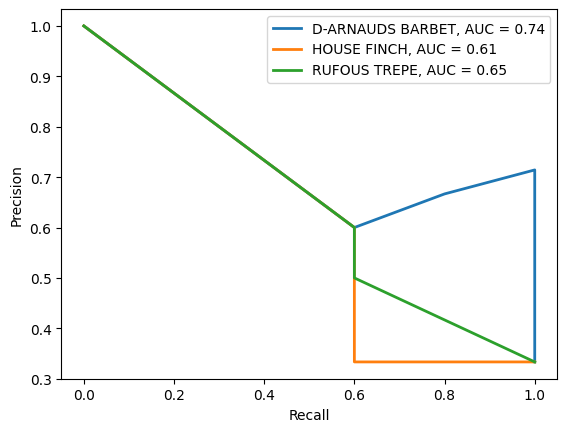

In [19]:
# calculating the precision-recall curve and the area under the curve (AUC) for each class.
y_true_one_hot = to_categorical(y_true)
class_names = {v: k for k, v in val_generator.class_indices.items()}

for i in range(3):
    precision, recall, _ = precision_recall_curve(y_true_one_hot[:, i], y_pred[:, i])
    auc_score = auc(recall, precision)
    class_name = class_names[i]
    print(f'AUC for {class_name}: {auc_score}')
    plt.plot(recall, precision, lw=2, label='{}, AUC = {:.2f}'.format(class_name, auc_score))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

##### Some example of missclassified species:

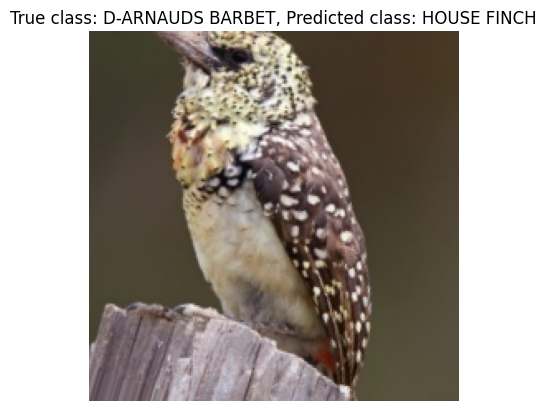

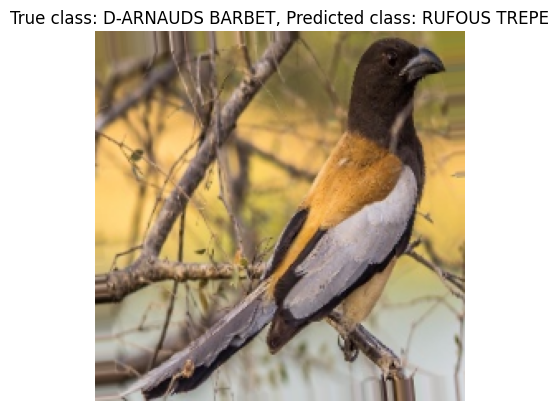

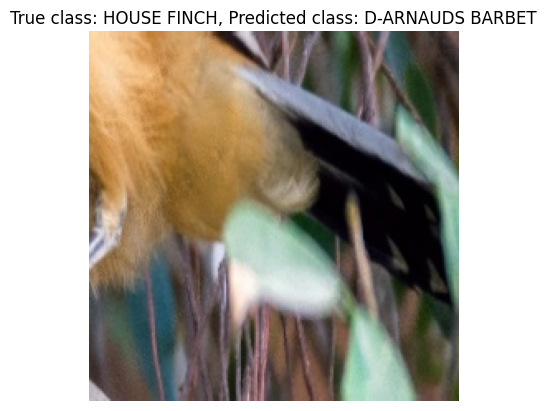

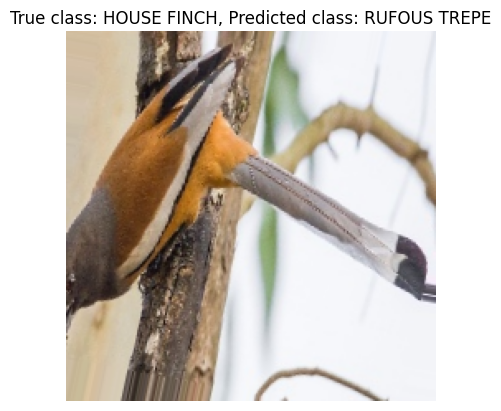

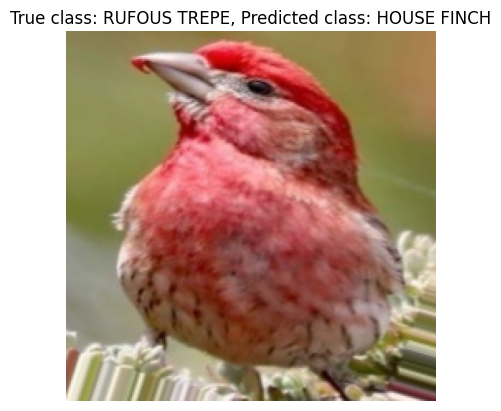

In [20]:
# plotting missclassified examples
misclassfied_index = np.where(y_predict!= y_true)[0]


for index in misclassfied_index[:5]:
    # get image from corresponding batch
    img_batch, _ = val_generator[index // val_generator.batch_size]
    img = img_batch[index % val_generator.batch_size]
    
    true_class_name = class_names[y_true[index]]
    predicted_class_name = class_names[y_predict[index]]

    plt.imshow(img.astype('uint8'))
    plt.title(f'True class: {true_class_name}, Predicted class: {predicted_class_name}')
    plt.axis('off')
    plt.show()